In [161]:
# Common
import os 
import keras 
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output as cls

In [162]:
# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

In [163]:
# Data Loading
from keras.preprocessing.image import ImageDataGenerator as IDG

In [164]:
# Model 
import tensorflow_hub as hub
from keras.layers import Dense
from keras.models import Sequential, load_model

In [165]:
# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [166]:
# LR Scheduler
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay as PWCD
from tensorflow.keras.optimizers import SGD


In [167]:
# Metrics
from keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

In [168]:
# Specify Data Path
path = './Dataset'

# Class Name
class_names = sorted(os.listdir(path))
# class_names.remove("Poses.json")
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Classes : \n{class_names}")

Total Number of Classes : 47
Classes : 
['Adho Mukha Svanasana', 'Adho Mukha Vrksasana', 'Alanasana', 'Anjaneyasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Navasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bitilasana', 'Camatkarasana', 'Dhanurasana', 'Eka Pada Rajakapotasana', 'Garudasana', 'Halasana', 'Hanumanasana', 'Malasana', 'Marjaryasana', 'Navasana', 'Padmasana', 'Parsva Virabhadrasana', 'Parsvottanasana', 'Paschimottanasana', 'Phalakasana', 'Pincha Mayurasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Setu Bandha Sarvangasana', 'Sivasana', 'Supta Kapotasana', 'Trikonasana', 'Upavistha Konasana', 'Urdhva Dhanurasana', 'Urdhva Mukha Svsnssana', 'Ustrasana', 'Utkatasana', 'Uttanasana', 'Utthita Hasta Padangusthasana', 'Utthita Parsvakonasana', 'Vasisthasana', 'Virabhadrasana One', 'Virabhadrasana Three', 'Virabhadrasana Two', 'Vrksasana']


In [169]:
# Calculate Class Dis
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]

In [170]:
# Pie Plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

# Bar Plot
fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()


In [171]:
# Initialize Generators
train_gen = IDG(rescale=1./255, rotation_range=10, validation_split=0.1)

In [172]:
# Load Data
train_ds = train_gen.flow_from_directory(path, target_size=(256,256), class_mode='binary', shuffle=True, batch_size=32, subset='training')
valid_ds = train_gen.flow_from_directory(path, target_size=(256,256), class_mode='binary', shuffle=True, batch_size=32, subset='validation')

Found 2500 images belonging to 47 classes.
Found 256 images belonging to 47 classes.


In [173]:
def show_images(data, model=None, GRID=[5,6], SIZE=(25,25)):
    
    # Plot Configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    i = 1
    for images, labels in iter(data):
        
        # Select Random Data
        
        id = np.random.randint(len(images))
        image, label = tf.expand_dims(images[id], axis=0), class_names[int(labels[id])]
        # Make Prediction
        if model is not None:
            pred = class_names[np.argmax(model.predict(image))]
            title = f"True : {label}\nPred : {pred}"
            return pred
        else:
            title = f"{label}"
        
        # Show Data
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(title)
        
        # Break Loop Once Done
        i+=1
        if i>n_images:
            break
        cls()
    # print(pred)
    # plt.show()
    # return pred   


CPU times: total: 1.53 s
Wall time: 12.9 s


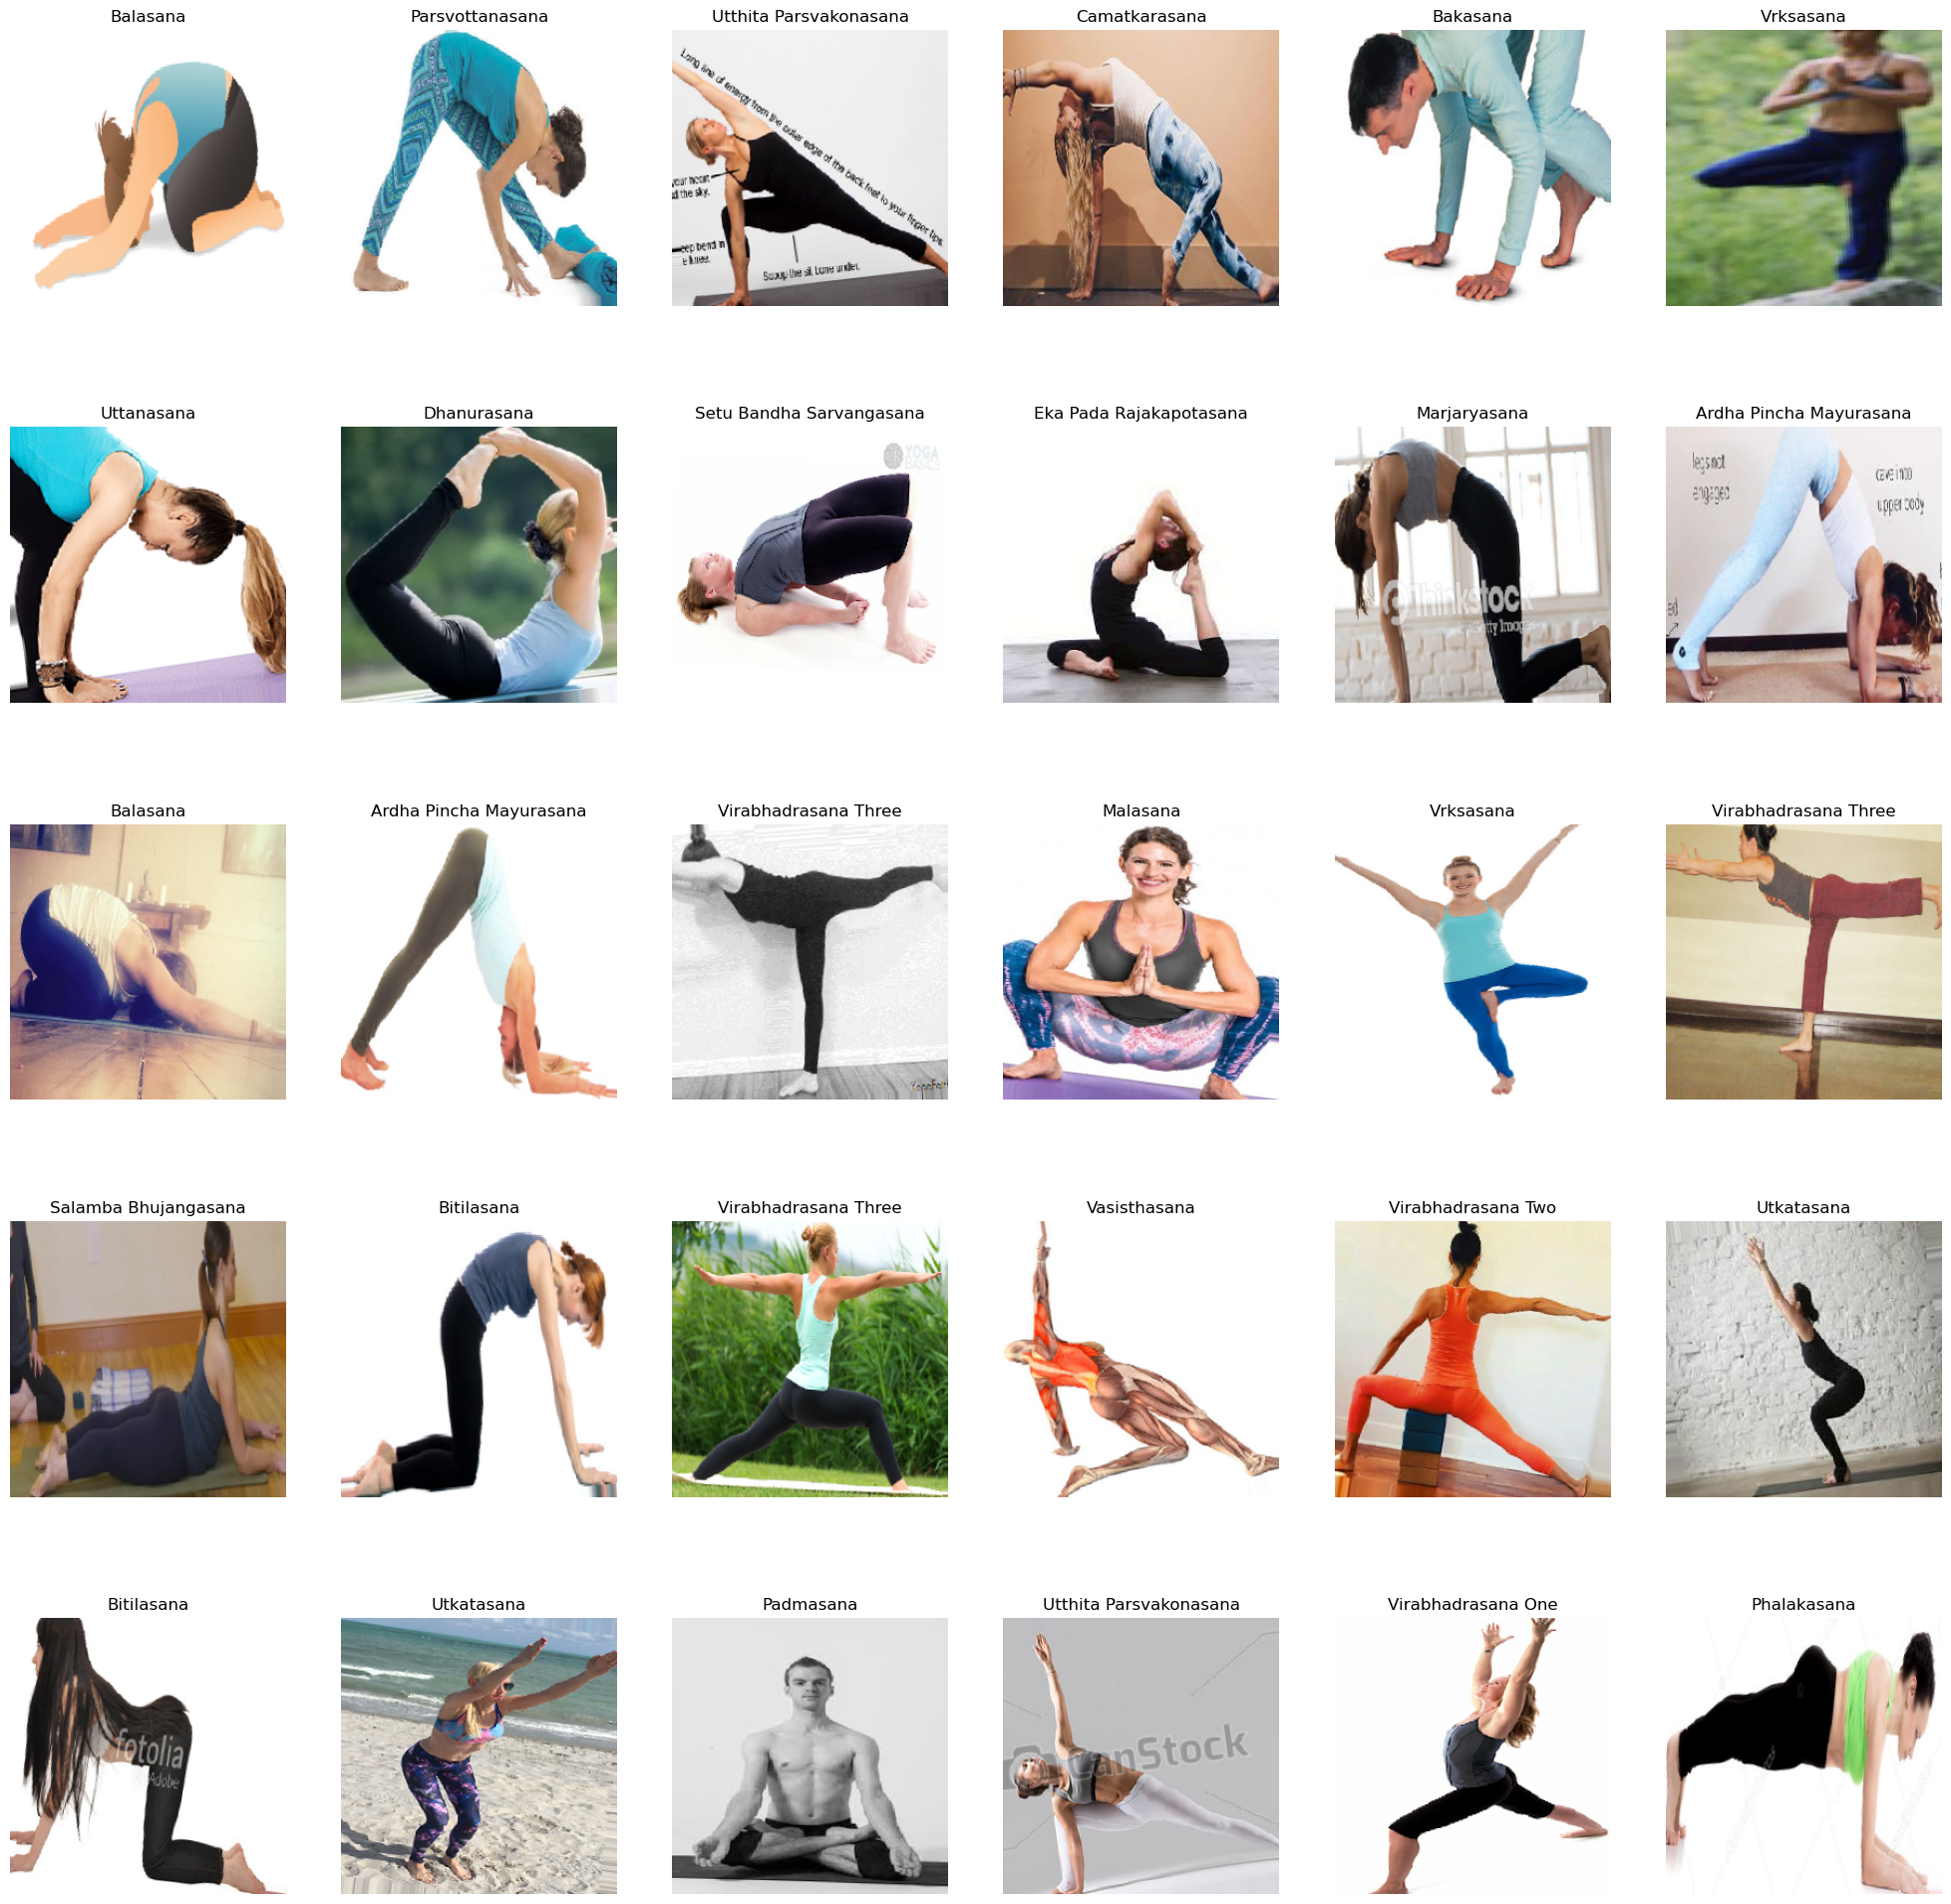

In [174]:
%%time
show_images(data=train_ds)

In [175]:
# Model URL
url = "https://tfhub.dev/google/bit/m-r50x1/1"

# Load Model
bit = hub.KerasLayer(url)

In [176]:
# Model Name
model_name = "Yoga-Posture-Detection-BiT"

# Model Architecture
model = Sequential([
    bit,
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name=model_name)

In [177]:
# Optimizer
learning_rate = 5e-2 * 32/512
lr_scheduler = PWCD(
    boundaries=[
        100,
        150,
        200
    ],
    values = [
        learning_rate,
        learning_rate*0.1,
        learning_rate*0.01,
        learning_rate*0.001
    ], name="LearningRate"
)
optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
print(f"Learning Rate : {learning_rate}")

Learning Rate : 0.003125


In [178]:
# Compile Model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        SparseCategoricalAccuracy(name="accuracy"),
        SparseTopKCategoricalAccuracy(k=3, name="Top3Acc")
    ]
)

In [179]:
# Callbacks
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(model_name+".h5", save_best_only=True)
]

In [180]:
# Train Model
history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=10, # With the right learning rate, only 5 will also work.
    callbacks=cbs
)

Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 7.9535 - accuracy: 0.2296 - Top3Acc: 0.3968

C:\Users\Bat_Sheva\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



79/79 [==============================] - 218s 2s/step - loss: 7.9535 - accuracy: 0.2296 - Top3Acc: 0.3968 - val_loss: 4.4909 - val_accuracy: 0.4531 - val_Top3Acc: 0.6367
Epoch 2/10
79/79 [==============================] - 171s 2s/step - loss: 2.8455 - accuracy: 0.5792 - Top3Acc: 0.7708 - val_loss: 1.4791 - val_accuracy: 0.6836 - val_Top3Acc: 0.8516
Epoch 3/10
79/79 [==============================] - 172s 2s/step - loss: 0.8777 - accuracy: 0.7824 - Top3Acc: 0.9344 - val_loss: 1.4217 - val_accuracy: 0.6523 - val_Top3Acc: 0.8750
Epoch 4/10
79/79 [==============================] - 208s 3s/step - loss: 0.7963 - accuracy: 0.7960 - Top3Acc: 0.9456 - val_loss: 1.3518 - val_accuracy: 0.6875 - val_Top3Acc: 0.8633
Epoch 5/10
79/79 [==============================] - 174s 2s/step - loss: 0.7778 - accuracy: 0.8080 - Top3Acc: 0.9420 - val_loss: 1.4129 - val_accuracy: 0.6680 - val_Top3Acc: 0.8633
Epoch 6/10
79/79 [==============================] - 172s 2s/step - loss: 0.7689 - accuracy: 0.8052 - Top3A

In [181]:
data = pd.DataFrame(history.history)
data

,loss,accuracy,Top3Acc,val_loss,val_accuracy,val_Top3Acc
0,7.953471,0.2296,0.3968,4.490907,0.453125,0.636719
1,2.845512,0.5792,0.7708,1.479084,0.683594,0.851562
2,0.877688,0.7824,0.9344,1.421665,0.652344,0.875000
3,0.796347,0.7960,0.9456,1.351811,0.687500,0.863281
4,0.777809,0.8080,0.9420,1.412859,0.667969,0.863281
5,0.768949,0.8052,0.9464,1.367027,0.699219,0.878906
6,0.764467,0.8108,0.9500,1.254171,0.695312,0.882812
7,0.742723,0.8120,0.9468,1.282262,0.695312,0.878906
8,0.724984,0.8072,0.9492,1.323814,0.675781,0.871094
9,0.721785,0.8172,0.9472,1.276231,0.687500,0.875000


In [182]:
def plot_learning_curve(history):
    data = pd.DataFrame(history)
    
    plt.style.use('fast')
    plt.figure(figsize=(25,8))

    plt.subplot(1,3,1)
    plt.title("Loss Curve")
    plt.plot(data['loss'], label="Loss")
    plt.plot(data['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.legend(fontsize=15)
    plt.ylabel("Loss")

    plt.subplot(1,3,2)
    plt.title("Accuracy Curve")
    plt.plot(data['accuracy'], label="Accuracy")
    plt.plot(data['val_accuracy'], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.legend(fontsize=15)
    plt.ylabel("Accuracy")

    plt.subplot(1,3,3)
    plt.title("Top 3 Accuracy Curve")
    plt.plot(data['Top3Acc'], label="Top 3 Accuracy")
    plt.plot(data['val_Top3Acc'], label="Top 3 Val Accuracy")
    plt.xlabel("Epochs")
    plt.legend(fontsize=15)
    plt.ylabel("Accuracy")
    
    plt.show()

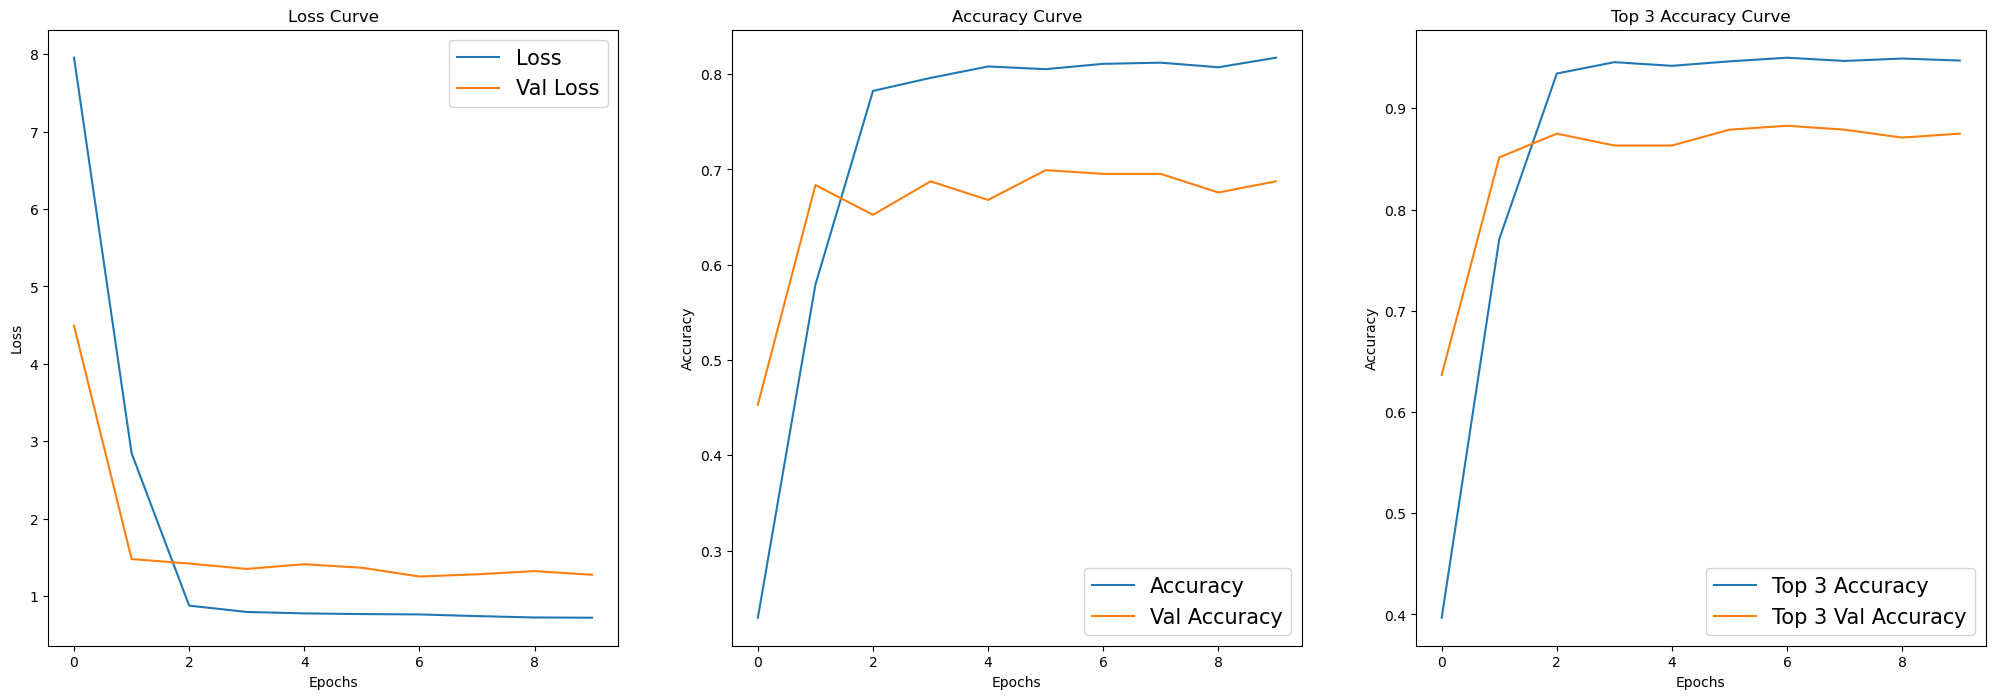

In [183]:
plot_learning_curve(history.history)

In [184]:
model.evaluate(valid_ds)

8/8 [==============================] - 17s 2s/step - loss: 1.3567 - accuracy: 0.6719 - Top3Acc: 0.8672


[1.356687068939209, 0.671875, 0.8671875]

In [185]:
# Save Model and Weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")

In [186]:
show_images(data=valid_ds, model=model)

1/1 [==============================] - 1s 1s/step


'Sivasana'

<Figure size 2500x2500 with 0 Axes>

In [187]:
path_i = './Dataset3/'
valid_ds1 = train_gen.flow_from_directory(path_i, target_size=(256,256), class_mode='binary', shuffle=True, batch_size=32, subset='validation')

Found 213 images belonging to 9 classes.


In [188]:
show_images(data=valid_ds1, model=model)

1/1 [==============================] - 0s 280ms/step


'Adho Mukha Svanasana'

<Figure size 2500x2500 with 0 Axes>

In [189]:
import shutil
import os
from keras.preprocessing.image import ImageDataGenerator

# יצירת תיקייה זמנית
temp_dir = 'temp_directory/directory'
os.makedirs(temp_dir, exist_ok=True)
path_i = rf"C:\Users\Bat_Sheva\OneDrive\שולחן העבודה\yoga\yoga-images (2).jpg"
# העתקת התמונה לתיקייה זו
shutil.copy(path_i, temp_dir)


path_4 = 'temp_directory'
for subdir, dirs, files in os.walk(path_4):
    print(f"Directory: {subdir}")
    for file in files:
        print(f"  File: {file}")

from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rescale=1./255)

train_gen1 = data_generator.flow_from_directory(
    path_4,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True,
    batch_size=1
)

Directory: temp_directory
Directory: temp_directory\directory
  File: yoga-images (2).jpg
Found 1 images belonging to 1 classes.


In [1]:
# valid_ds2 = train_gen.flow_from_directory(path_4, class_mode='binary', shuffle=True, batch_size=1, subset='validation')
pred = show_images(data=train_gen1, model=model, GRID=(1,1), SIZE=(1,1))
pred

NameError: name 'show_images' is not defined

In [191]:
import plotly.express as px

In [11]:
from keras.models import load_model
model = load_model('./Yoga-Posture-Detection-BiT.h5')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 32: invalid continuation byte